# New Inference

In [1]:
!pip install "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [2]:
!git  clone https://github.com/rohitgandikota/sliders.git
!cd sliders
!pip install -r sliders/requirements.txt
!pip install accelerate
import os
os.chdir('sliders')
# !wget https://sliders.baulab.info/weights/xl_sliders/muscular.pt

fatal: destination path 'sliders' already exists and is not an empty directory.


In [3]:
import torch
from PIL import Image
import argparse
import os, json, random
import pandas as pd
import matplotlib.pyplot as plt
import glob, re

from tqdm.notebook import tqdm
import numpy as np

from safetensors.torch import load_file
import matplotlib.image as mpimg
import copy
import gc
from transformers import CLIPTextModel, CLIPTokenizer

import diffusers
from diffusers import DiffusionPipeline
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel, LMSDiscreteScheduler
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor, AttentionProcessor
from typing import Any, Dict, List, Optional, Tuple, Union
from trainscripts.textsliders.lora import LoRANetwork, DEFAULT_TARGET_REPLACE, UNET_TARGET_REPLACE_MODULE_CONV

In [4]:
def flush():
    torch.cuda.empty_cache()
    gc.collect()
flush()
width = 512
height = 512
steps = 50
cfg_scale = 7.5
pretrained_sd_model = "CompVis/stable-diffusion-v1-4"

In [5]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"

revision = None
device = 'cuda:0'
rank = 4
weight_dtype = torch.float16

# Load scheduler, tokenizer and models.
noise_scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path, subfolder="tokenizer", revision=revision
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", revision=revision
)
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet", revision=revision
)
# freeze parameters of models to save more memory
unet.requires_grad_(False)
unet.to(device, dtype=weight_dtype)
vae.requires_grad_(False)

text_encoder.requires_grad_(False)

# For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.


# Move unet, vae and text_encoder to device and cast to weight_dtype
vae.requires_grad_(False)
vae.to(device, dtype=weight_dtype)
text_encoder.to(device, dtype=weight_dtype)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [7]:
!wget https://sliders.baulab.info/weights/sd14_sliders/chubby_sd14.pt

--2024-04-24 21:53:19--  https://sliders.baulab.info/weights/sd14_sliders/chubby_sd14.pt
Resolving sliders.baulab.info (sliders.baulab.info)... 35.232.255.106
Connecting to sliders.baulab.info (sliders.baulab.info)|35.232.255.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6025989 (5.7M)
Saving to: ‘chubby_sd14.pt’

chubby_sd14.pt      100%[===================>]   5.75M  14.8MB/s    in 0.4s    

2024-04-24 21:53:19 (14.8 MB/s) - ‘chubby_sd14.pt’ saved [6025989/6025989]



In [8]:
# path to your model file
lora_weights = [
    'chubby_sd14.pt',
]

In [12]:
seed = random.randint(0, 5000)

create LoRA for U-Net: 150 modules.
image of man standing 2652


<ipython-input-15-f1c553f91134>:96: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

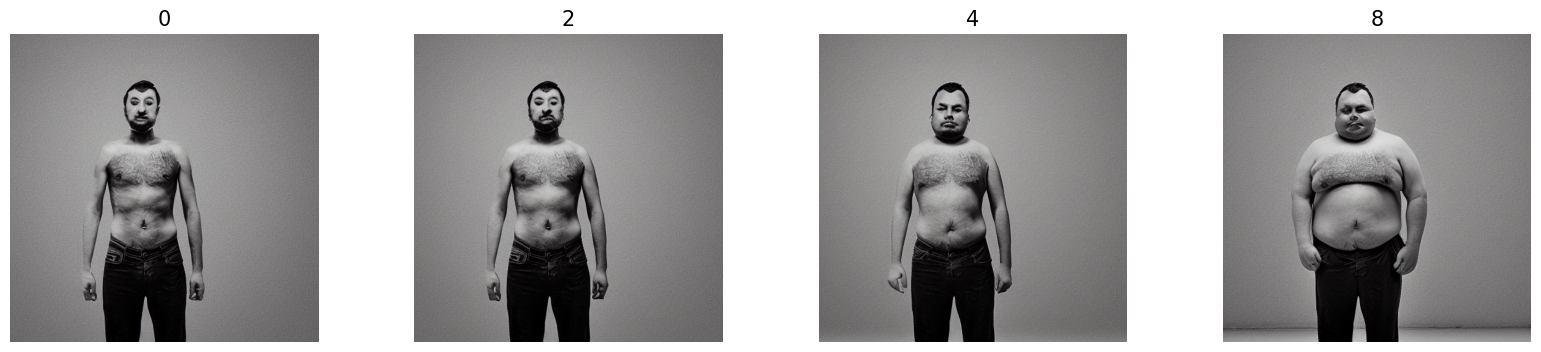

In [15]:
# prompts to try
prompts = [
#             "image of a person, 8k, realistic",
            "image of man standing",
           ]
# LoRA weights/scale to test
scales = [0, 2, 4, 8]

# timestep during inference when we switch to LoRA scale>0 (this is done to ensure structure in the images)
start_noise = 800

latent_finals = []
latexnt_x_primes = []

#number of images per prompt
num_images_per_prompt = 1

torch_device = device
negative_prompt = None
batch_size = 1
height = 512
width = 512
ddim_steps = 50
guidance_scale = 7.5

for prompt in prompts:
    # for different seeds on same prompt
    for _ in range(num_images_per_prompt):
        for lora_weight in lora_weights:

            if 'full' in lora_weight:
                train_method = 'full'
            elif 'noxattn' in lora_weight:
                train_method = 'noxattn'
            else:
                train_method = 'noxattn'

            network_type = "c3lier"
            if train_method == 'xattn':
                network_type = 'lierla'

            modules = DEFAULT_TARGET_REPLACE
            if network_type == "c3lier":
                modules += UNET_TARGET_REPLACE_MODULE_CONV
            import os
            model_name = lora_weight

            name = os.path.basename(model_name)
            unet = UNet2DConditionModel.from_pretrained(
                pretrained_model_name_or_path, subfolder="unet", revision=revision
            )
            # freeze parameters of models to save more memory
            unet.requires_grad_(False)
            unet.to(device, dtype=weight_dtype)
            rank = 4
            alpha = 1
            if 'rank4' in lora_weight:
                rank = 4
            if 'rank8' in lora_weight:
                rank = 8
            if 'alpha1' in lora_weight:
                alpha = 1.0
            network = LoRANetwork(
                    unet,
                    rank=rank,
                    multiplier=1.0,
                    alpha=alpha,
                    train_method=train_method,
                ).to(device, dtype=weight_dtype)
            network.load_state_dict(torch.load(lora_weight))
            images_list = []

            print(prompt, seed)

            for scale in scales:

                generator = torch.manual_seed(seed)
                text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

                text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

                max_length = text_input.input_ids.shape[-1]
                if negative_prompt is None:
                    uncond_input = tokenizer(
                        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
                    )
                else:
                    uncond_input = tokenizer(
                        [negative_prompt] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
                    )
                uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

                text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

                latents = torch.randn(
                    (batch_size, unet.in_channels, height // 8, width // 8),
                    generator=generator,
                )
                latents = latents.to(torch_device)

                noise_scheduler.set_timesteps(ddim_steps)
                latexnt_x_primes.append(latents)

                latents = latents * noise_scheduler.init_noise_sigma
                latents = latents.to(weight_dtype)
                latent_model_input = torch.cat([latents] * 2)

                for t in tqdm(noise_scheduler.timesteps):
                    if t>start_noise:
                        network.set_lora_slider(scale=0)
                    else:
                        network.set_lora_slider(scale=scale)
                    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
                    latent_model_input = torch.cat([latents] * 2)

                    latent_model_input = noise_scheduler.scale_model_input(latent_model_input, timestep=t)
                    # predict the noise residual
                    with network:
                        with torch.no_grad():
                            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
                    # perform guidance
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                    # compute the previous noisy sample x_t -> x_t-1
                    latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

                # scale and decode the image latents with vae
                latent_finals.append(latents)
                latents = 1 / 0.18215 * latents
                with torch.no_grad():
                    image = vae.decode(latents).sample
                image = (image / 2 + 0.5).clamp(0, 1)
                image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
                images = (image * 255).round().astype("uint8")
                pil_images = [Image.fromarray(image) for image in images]
                images_list.append(pil_images[0])
            del network, unet
            unet = None
            network = None
            torch.cuda.empty_cache()
            flush()
            fig, ax = plt.subplots(1, len(images_list), figsize=(20,4))
            for i, a in enumerate(ax):
                a.imshow(images_list[i])
                a.set_title(f"{scales[i]}",fontsize=15)
                a.axis('off')

#             plt.suptitle(f"{os.path.basename(lora_weight).replace('.pt','')}", fontsize=20)

            # plt.tight_layout()
            plt.show()

In [22]:
cd 'drive/My Drive/PGM Data/chubby_results'

/content/drive/My Drive/PGM Data/chubby_results


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
torch.save(latent_finals, 'latent_finals_man_standing.pt')
torch.save(latexnt_x_primes, 'latent_x_primes.pt')

for i in range(4):
  images_list[i].save(f'chubby_man_standing_{scales[i]}.png')


In [26]:
print(seed)

2652
